In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
# import torch.utils.data
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import datasets

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Download Dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip -n lgg-mri-segmentation.zip

Archive:  lgg-mri-segmentation.zip


## Preprocess Data

(256, 256)


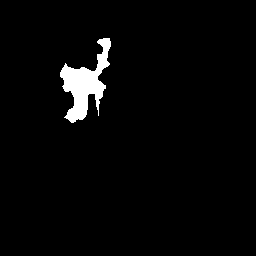

In [7]:
from PIL import Image
im = Image.open('kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif')
print(im.size)
im

In [8]:
#!rm -r dataset

In [9]:
!mkdir -p dataset

In [10]:
start_dir = 'kaggle_3m'
ANNOTATIONS = []

for roots, dirs, files in os.walk(start_dir):
    for dir in dirs:
        for r, d, f in os.walk(os.path.join(start_dir, dir)):
            for image in f:
                # pre, post = image.split('.')
                # print((pre + '_mask.' + post) not in f, image)
                # if 'mask' not in image and (pre + '_mask.' + post) not in f:
                #     mask = Image.new('RGB', (256, 256))
                #     mask.save('dataset/' + pre + '_mask.' + post)
                if 'mask' not in image:
                    ANNOTATIONS.append(image)
                im = Image.open(r + '/' + image)
                im.save('dataset/' + image)
print(len(ANNOTATIONS))

3929


In [11]:
CANCER_ANNOTATIONS = []
NO_CANCER_ANNOTATIONS = []

for im in ANNOTATIONS:
    pre, post = im.split('.')
    mask = pre + '_mask.' + post
    mask = Image.open('dataset/' + mask).convert('L').getextrema()
    if mask == (0, 0):
        NO_CANCER_ANNOTATIONS.append(im)
    else:
        CANCER_ANNOTATIONS.append(im)

print(len(CANCER_ANNOTATIONS), len(NO_CANCER_ANNOTATIONS))

1373 2556


In [12]:
def show_images(annotations):
    fig, axis = plt.subplots(4, 8, figsize=(20, 10))

    i = j = 0
    for idx, im in enumerate(annotations):
        pre, post = im.split('.')
        mask = pre + '_mask.' + post
        mask = Image.open('dataset/' + mask).convert('L')
        
        img = np.array(mask)

        i = idx % 4
        j = idx // 4
        axis[i][j].imshow(img, cmap='gray')
        axis[i][j].set_xticklabels([])
        axis[i][j].set_yticklabels([])
        axis[i][j].set_aspect('equal')
    plt.show()

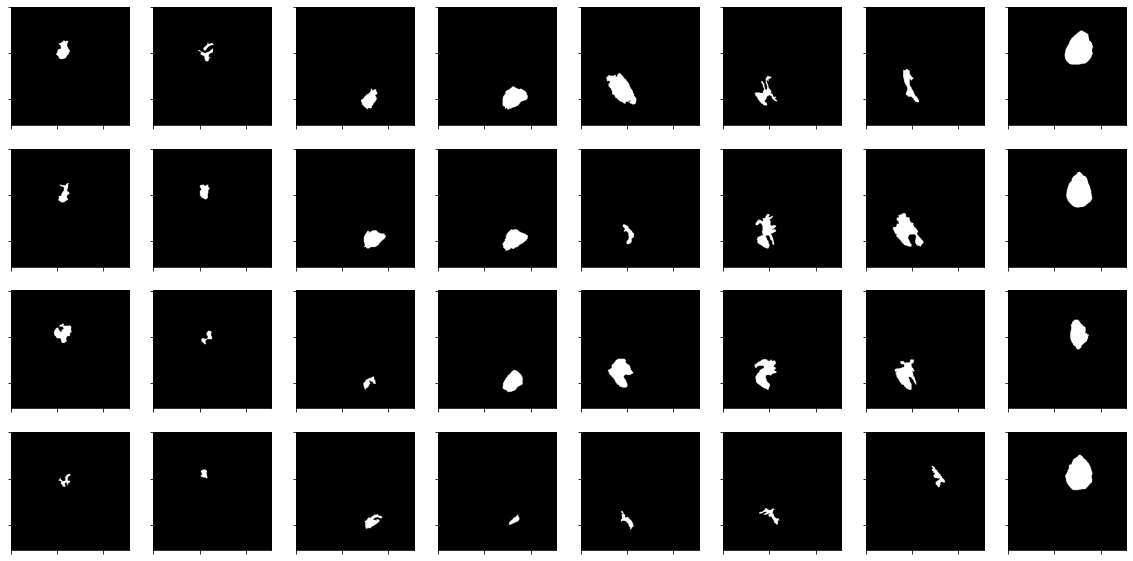

In [13]:
show_images(CANCER_ANNOTATIONS[:32])

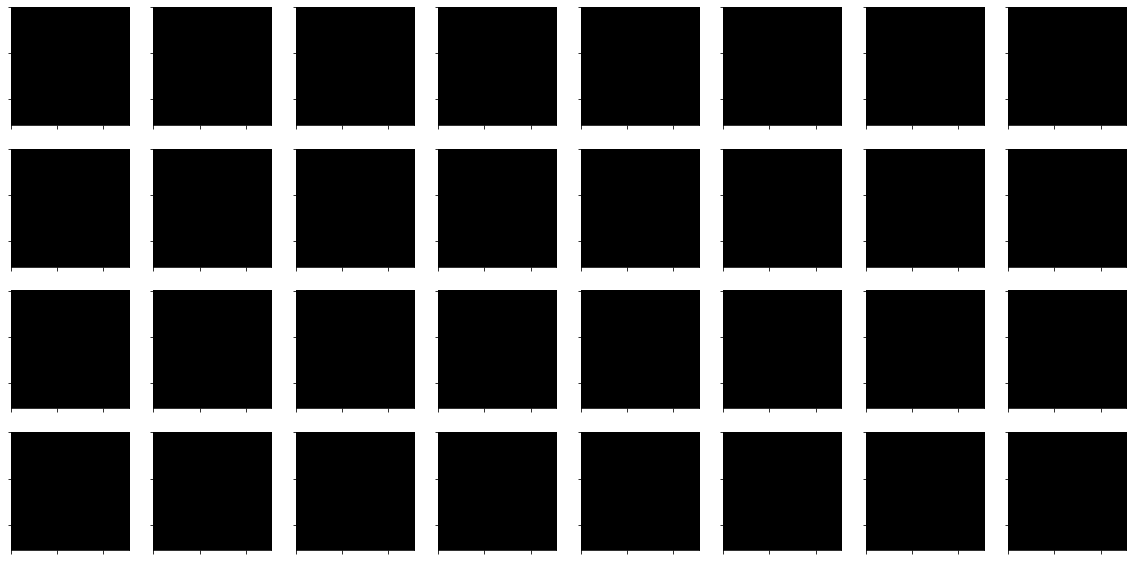

In [14]:
show_images(NO_CANCER_ANNOTATIONS[:32])

## Data loaders


In [15]:
import random

class CustomDataset(Dataset):
    def __init__(self, annotations, image_dir, train=False):
        self.annotations = annotations
        self.image_dir = image_dir
        self.train = train

    def train_transforms(self, image, mask):
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256)
        )
        image = transforms.functional.crop(image, i, j, h, w)
        mask = transforms.functional.crop(mask, i, j, h, w)

        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        
        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        return image, mask

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image = self.annotations[index]
        pre, post = image.split('.')
        mask = pre + '_mask.' + post

        image = Image.open(os.path.join(self.image_dir, image)).convert('L')
        mask = Image.open(os.path.join(self.image_dir, mask)).convert('L')

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)

        if self.train:
            image, mask = self.train_transforms(image, mask)

        mask = mask.squeeze(0).long()

        return image, mask

In [16]:
from random import shuffle

## Create balanced annotations for better generalization

shuffle(CANCER_ANNOTATIONS)
shuffle(NO_CANCER_ANNOTATIONS)

train_c = CANCER_ANNOTATIONS[:int(len(CANCER_ANNOTATIONS) * 0.7)]
test_c = CANCER_ANNOTATIONS[int(len(CANCER_ANNOTATIONS) * 0.7):int(len(CANCER_ANNOTATIONS) * 0.85)]
val_c = CANCER_ANNOTATIONS[int(len(CANCER_ANNOTATIONS) * 0.85):]
train_noc = NO_CANCER_ANNOTATIONS[:int(len(NO_CANCER_ANNOTATIONS) * 0.7)]
test_noc = NO_CANCER_ANNOTATIONS[int(len(NO_CANCER_ANNOTATIONS) * 0.7):int(len(NO_CANCER_ANNOTATIONS) * 0.85)]
val_noc = NO_CANCER_ANNOTATIONS[int(len(NO_CANCER_ANNOTATIONS) * 0.85):]

shuffle(train_noc)
shuffle(test_noc)
shuffle(val_noc)

train_a = train_c + train_noc[:len(train_c)]
test_a = test_c + test_noc[:len(test_c)]
val_a = val_c + val_noc[:len(val_c)]

shuffle(train_a)
shuffle(test_a)
shuffle(val_a)

In [17]:
test_dataset = CustomDataset(train_a[:64], 'dataset', True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for im, target in test_loader:
    print(im.shape)
    print(target.shape)
    print('//////////')

torch.Size([32, 1, 256, 256])
torch.Size([32, 256, 256])
//////////
torch.Size([32, 1, 256, 256])
torch.Size([32, 256, 256])
//////////


## Train functions


In [18]:
from tqdm import tqdm

def step(model, data_loader, optimizer, loss, epoch, grad_scaler, mode="Train", device="cuda"):
    tq = tqdm(data_loader, leave=True, desc=mode + " " + str(epoch))
    losses = []
    dice_losses = []

    if mode == 'Train':
        model.train()
    else:
        model.eval()

    for i, (data, target) in enumerate(tq):
        data = data.to(device)
        target = target.to(device)

        with torch.set_grad_enabled(mode == 'Train'):
            if mode == 'Train':
                if device != 'cpu':
                    with torch.cuda.amp.autocast():
                        mask_pred = model(data)
                        l, d_l = loss(mask_pred, target, model.n_classes)
                else:
                    mask_pred = model(data)
                    l, d_l = loss(mask_pred, target, model.n_classes)
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(l).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
            else:
                mask_pred = model(data)
                l, d_l = loss(mask_pred, target, model.n_classes)

        losses.append(l.detach().item())
        dice_losses.append(d_l.detach().item())
        tq.set_postfix(loss=(sum(losses)/len(losses)), dice=sum(dice_losses) / len(dice_losses))

    return sum(losses) / len(losses), sum(dice_losses) / len(dice_losses)


In [19]:
def train(model, train_loader, val_loader, test_loader, optimizer, loss,
          epochs, name="test_name", continue_training=False, device="cuda"):
    
    best_loss = None
    start_epoch = 0
    dir = "drive/MyDrive/trained_models/" + name + "/model.ph"
    if continue_training and os.path.exists(dir):
        checkpoint = torch.load(dir)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_loss = checkpoint['loss']
    
    best_model = model.state_dict()
    
    grad_scaler = torch.cuda.amp.GradScaler()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    history = {}
    history['train_loss'] = []
    history['train_dice_coef'] = []
    history['val_loss'] = []
    history['val_dice_coef'] = []
    history['test_loss'] = 0
    history['test_dice_coef'] = 0

    patience = 10

    for epoch in range(1 + start_epoch, 1 + epochs):
        train_loss, train_dice_loss = step(model, train_loader, optimizer, loss,
                          epoch, grad_scaler, "Train", device)
        history['train_loss'].append(train_loss)
        history['train_dice_coef'].append(train_dice_loss)

        val_loss, val_dice_loss = step(model, train_loader, optimizer, loss,
                          epoch, grad_scaler, "Val", device)
        history['val_loss'].append(val_loss)
        history['val_dice_coef'].append(val_dice_loss)

        scheduler.step(val_dice_loss)

        if best_loss is None or best_loss > val_loss:
            patience = 10
            best_loss = val_loss
            best_model = model.state_dict()

            dir = "drive/MyDrive/trained_models/" + name
            if not os.path.exists(dir):
                os.makedirs(dir)
            
            path = dir + '/model.ph'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, path)

        if patience == 0:
            break
        patience -= 1

    test_loss, test_dice_loss = step(model, train_loader, optimizer, loss,
                          epoch, grad_scaler, "Test", device)
    history['test_loss'] = test_loss
    history['test_dice_coef'] = test_dice_loss

    model.load_state_dict(best_model)

    return history

## Loss function

In [20]:
def dice_coef(pred, target, epsilon=1e-6):
    if (pred.dim() == 2):
        inter = torch.dot(pred.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(pred) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter
        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        dice = 0
        for i in range(pred.shape[0]):
            dice += dice_coef(pred[i, ...], target[i, ...])
        return dice / pred.shape[0]

In [21]:
criterion = nn.CrossEntropyLoss()

def Loss(pred, target, n_classes):
    loss = criterion(pred, target.long())
    dice_l = dice_coef(F.softmax(pred, dim=1).float(),
                       F.one_hot(target, n_classes).permute(0, 3, 1, 2).float())
    loss += 1 - dice_l
    return loss, dice_l

## Model

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, between_channels=None):
        super().__init__()
        if between_channels is None:
            between_channels = out_channels

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, between_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(between_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(between_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.model(x)

In [23]:
class DecoderStep(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()

        layers = []

        if pooling:
            layers.append(nn.MaxPool2d(2))
        layers.append(ConvBlock(in_channels, out_channels))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [24]:
class EncoderStep(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.block = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.block = ConvBlock(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        d_y = x2.size()[2] - x1.size()[2]
        d_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [d_x // 2, d_x - d_x // 2,
                        d_y // 2, d_y - d_y // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)

In [25]:
class Unet(nn.Module):
    def __init__(self, n_classes):
        super(Unet, self).__init__()
        self.n_classes = n_classes

        self.dec1 = DecoderStep(1, 64, False)
        self.dec2 = DecoderStep(64, 128)
        self.dec3 = DecoderStep(128, 256)
        self.dec4 = DecoderStep(256, 512)
        self.dec5 = DecoderStep(512, 512)

        self.enc1 = EncoderStep(1024, 256, True)
        self.enc2 = EncoderStep(512, 128, True)
        self.enc3 = EncoderStep(256, 64, True)
        self.enc4 = EncoderStep(128, 64, True)
        self.pred = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.dec1(x)
        x2 = self.dec2(x1)
        x3 = self.dec3(x2)
        x4 = self.dec4(x3)
        x = self.dec5(x4)

        x = self.enc1(x, x4)
        x = self.enc2(x, x3)
        x = self.enc3(x, x2)
        x = self.enc4(x, x1)

        x = self.pred(x)
        return x

## Vizualization

In [26]:
def display_loss(history):
    ind = list(range(len(history['train_loss'])))
    plt.plot(ind, history['train_loss'], label='line1')
    plt.plot(ind, history['val_loss'], label='line2')
    plt.scatter(ind[-1], history['test_loss'], label='point1')

    plt.legend([
        'train_loss',
        'val_loss',
        'test_loss'
    ])

    plt.ylabel('Loss')
    plt.title('Losses plot')
    plt.show()

In [27]:
def display_dice_coef(history):
    ind = list(range(len(history['train_dice_coef'])))
    plt.plot(ind, history['train_dice_coef'], label='line1')
    plt.plot(ind, history['val_dice_coef'], label='line2')
    plt.scatter(ind[-1], history['test_dice_coef'], label='point1')

    plt.legend([
        'train_dice_coef',
        'val_dice_coef',
        'test_dice_coef'
    ])

    plt.ylabel('Coef')
    plt.title('Dice coef plot')
    plt.show()

In [48]:
from matplotlib.figure import AxesStack
def plot_images(model, annotations, device, save=False, name='example.png'):
    fig, ax = plt.subplots(len(annotations), 3, figsize=(5, 40))

    model.eval()
    for idx in range(len(annotations)):
        image = annotations[idx]
        pre, post = image.split('.')
        mask = pre + '_mask.' + post

        image = Image.open(os.path.join("dataset", image)).convert('L')
        mask = Image.open(os.path.join("dataset", mask)).convert('L')

        im = transforms.ToTensor()(image)

        resize = transforms.Resize(size=(256, 256))
        im = resize(im)
        im = im.unsqueeze(0)

        pred = model(im.to(device))
        pred = F.softmax(pred, dim=1)[0]
        pred = pred.cpu().squeeze()
        pred = F.one_hot(pred.argmax(dim=0), model.n_classes).permute(2, 0, 1).numpy()
        pred = np.argmax(pred, axis=0)

        image = np.array(image)
        mask = np.array(mask)

        ax[idx][0].imshow(image)
        ax[idx][0].set_title("Original image")
        ax[idx][0].set_xticklabels([])
        ax[idx][0].set_yticklabels([])
        ax[idx][0].set_aspect('equal')

        ax[idx][1].imshow(pred)
        ax[idx][1].set_title("Predicted mask")
        ax[idx][1].set_xticklabels([])
        ax[idx][1].set_yticklabels([])
        ax[idx][1].set_aspect('equal')

        ax[idx][2].imshow(mask)
        ax[idx][2].set_title("Original mask")
        ax[idx][2].set_xticklabels([])
        ax[idx][2].set_yticklabels([])
        ax[idx][2].set_aspect('equal')
    plt.tight_layout()
    if save:
        plt.savefig(name)
    else:
        plt.show()

## Test model and functions

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = Unet(2).to(device)
summary(unet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             576
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         ConvBlock-7         [-1, 64, 256, 256]               0
       DecoderStep-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,728
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,456
      BatchNorm2d-14        [-1, 128, 1

In [30]:
BATCH_SIZE = 2
train_dataset = CustomDataset(train_a[:4], 'dataset', True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_a[:4], 'dataset')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = CustomDataset(val_a[:4], 'dataset')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = Unet(2).to(device)
optimizer = optim.RMSprop(unet.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
loss = Loss

history = train(unet, train_loader, val_loader, test_loader, optimizer, loss,
          3, "test_name", False, device)

Test 3: 100%|██████████| 2/2 [00:00<00:00, 34.67it/s, dice=0.747, loss=1.05e+4]


In [31]:
unet = Unet(2).to(device)
optimizer = optim.RMSprop(unet.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
loss = Loss

train(unet, train_loader, val_loader, test_loader, optimizer, loss,
          5, "test_name", True, device)

Test 5: 100%|██████████| 2/2 [00:00<00:00, 35.34it/s, dice=0.747, loss=1.33e+3]


{'test_dice_coef': 0.7472168207168579,
 'test_loss': 1331.5096435546875,
 'train_dice_coef': [0.5234825909137726, 0.5252918601036072],
 'train_loss': [0.5193383991718292, 0.5153995156288147],
 'val_dice_coef': [0.7472168207168579, 0.7472168207168579],
 'val_loss': [2041.1658935546875, 1340.3654174804688]}

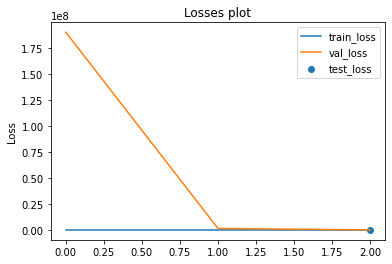

In [32]:
display_loss(history)

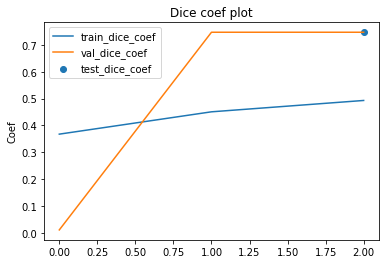

In [33]:
display_dice_coef(history)

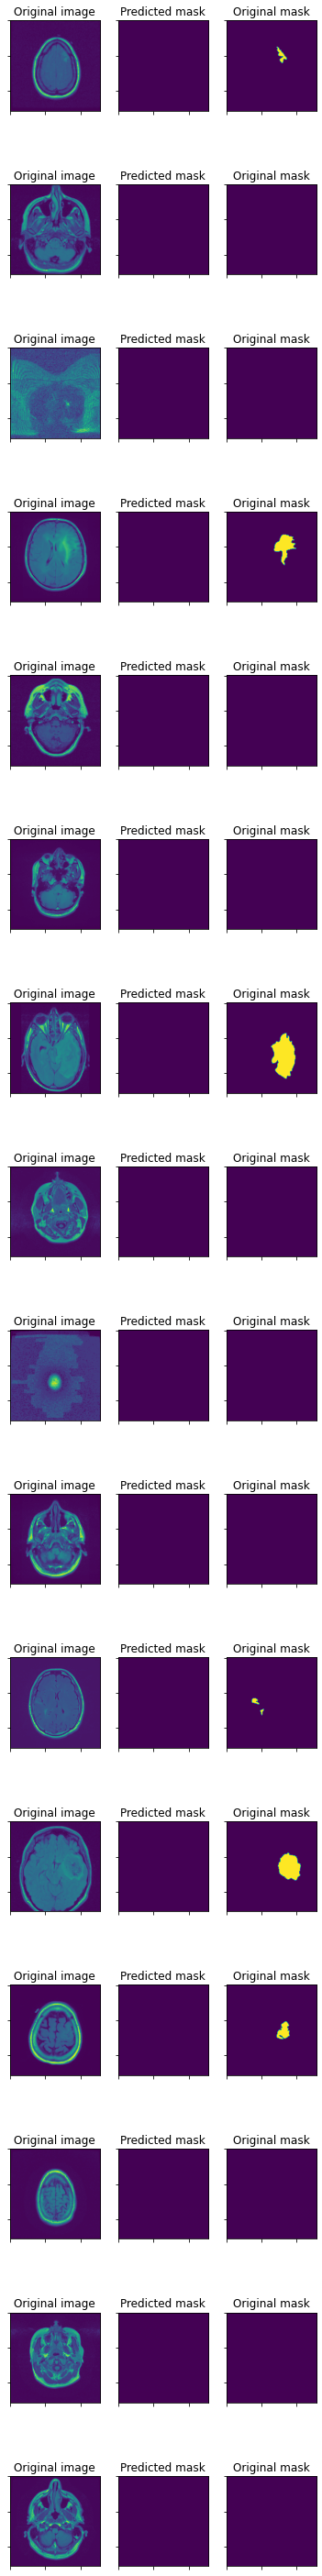

In [34]:
plot_images(unet, train_a[:16], device)

## Training

In [35]:
BATCH_SIZE = 32

In [36]:
train_dataset = CustomDataset(train_a, 'dataset', True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_a, 'dataset')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = CustomDataset(val_a, 'dataset')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
unet = Unet(2).to(device)
# optimizer = optim.RMSprop(unet.parameters(), lr=0.003, weight_decay=1e-4, momentum=0.9)
optimizer = optim.Adam(unet.parameters(), lr=0.01, weight_decay=1e-4)
loss = Loss

history = train(unet, train_loader, val_loader, test_loader, optimizer, loss,
          100, "brainSegmentation", True, device)

Test 56: 100%|██████████| 61/61 [00:23<00:00,  2.58it/s, dice=0.675, loss=0.346]


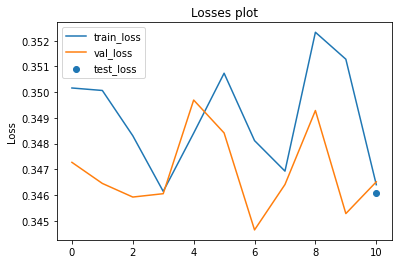

In [38]:
display_loss(history)

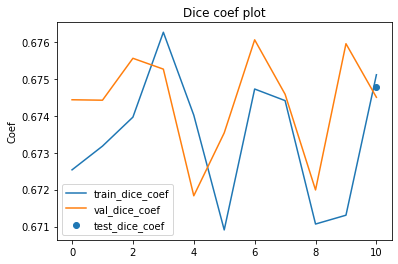

In [39]:
display_dice_coef(history)

In [40]:
history['test_loss']

0.3460937494137248

In [41]:
history['test_dice_coef']

0.6747782591913567

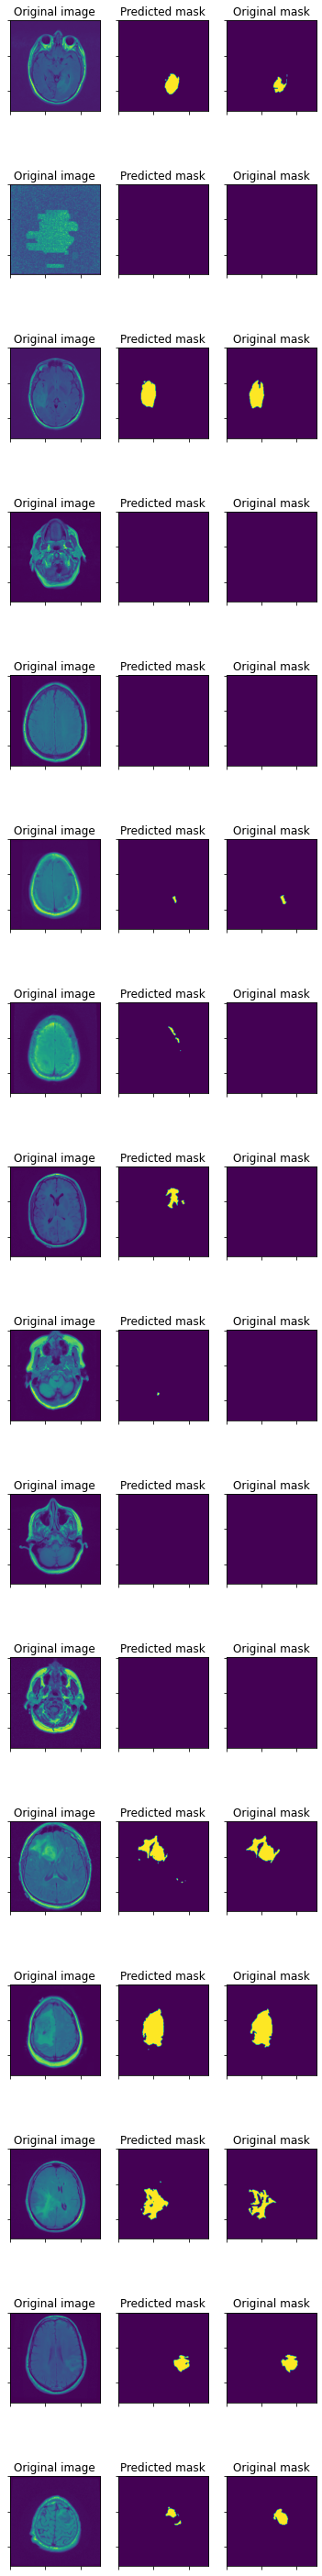

In [46]:
plot_images(unet, test_a[:16], device)

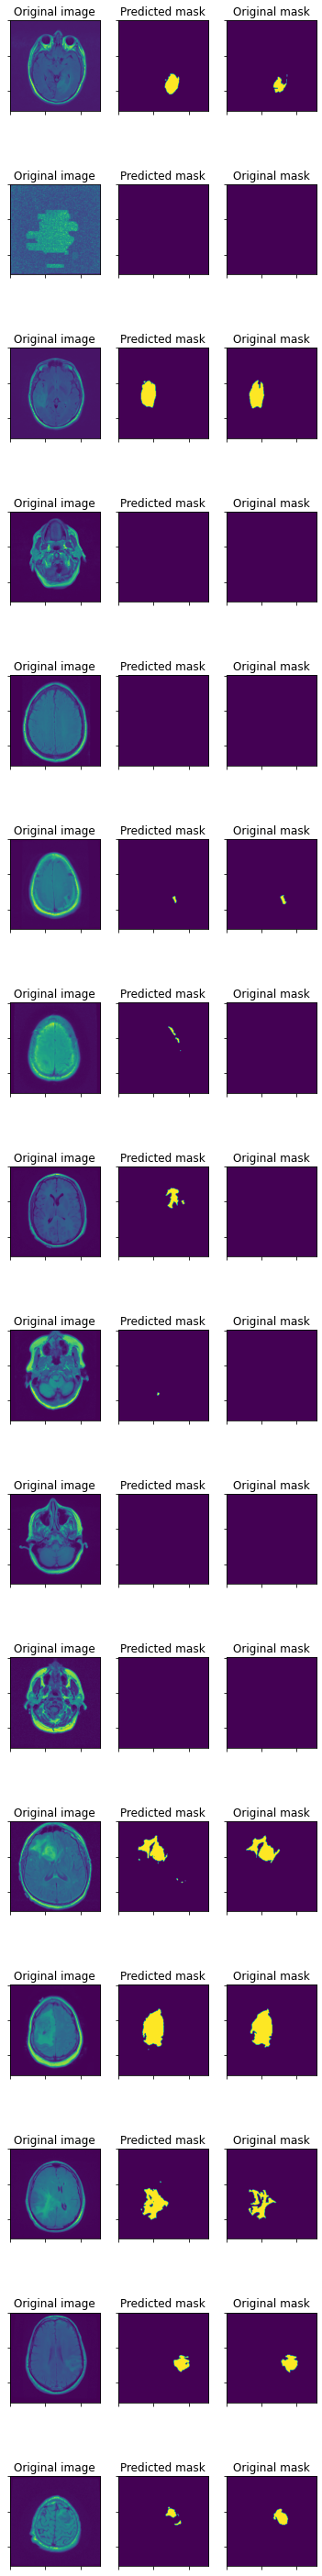

In [49]:
plot_images(unet, test_a[:16], device, True, 'brain.png')

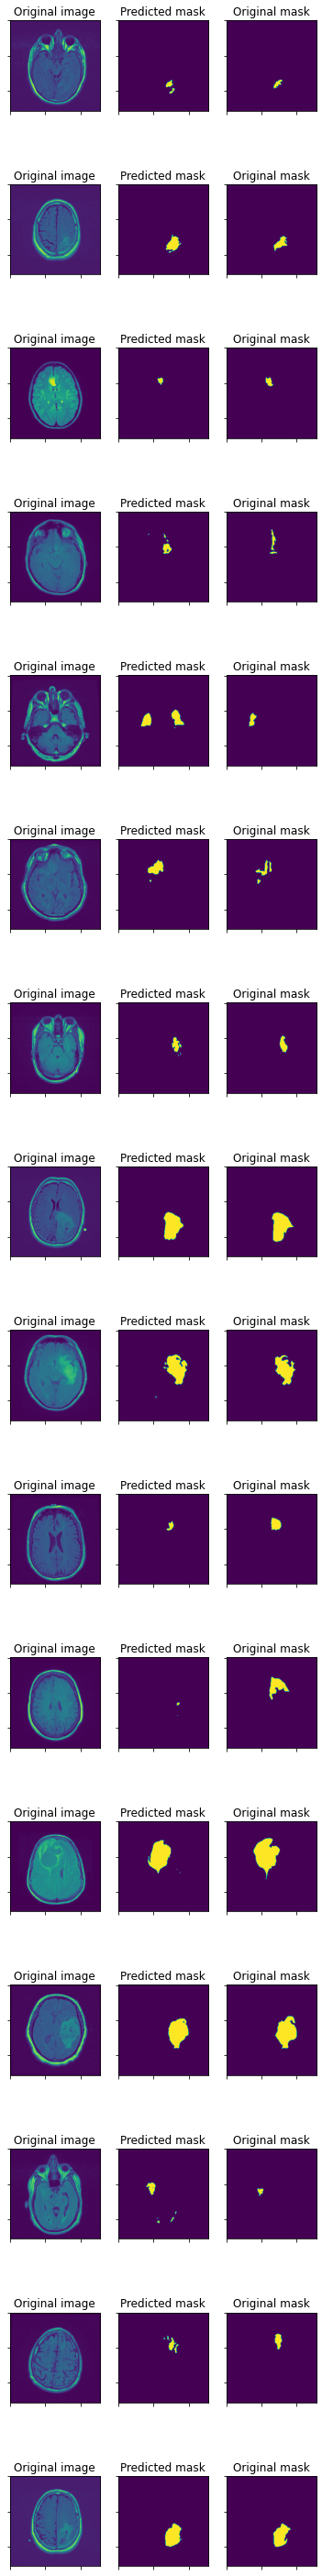

In [43]:
plot_images(unet, test_c[:16], device)